# **Test task 1 (Borys Melnychuk)**

Задача 1: Прогнозування попиту

Мета: Розробити систему прогнозування попиту на
короткостроковий період (14 днів) через 7 днів від останньої дати в
даних, для всіх груп товарів.

Опис:

1. Використовуючи надані дані про транзакції, створіть дві моделі
прогнозування:
 - Модель машинного навчання.
 - Класичну модель прогнозування часових рядів.
2. Дайте обґрунтовані коментарі щодо вибору методів та підходів,
поясніть, чому ви обрали саме їх.

3. Надати скрипт або ноутбук (.py/.ipynb), який буде містити
технічне рішення та можливість розрахунку прогнозу на майбутній
період (scoring).
Очікуваний результат: Файл з кодом (.py або .ipynb), який включає
дві моделі прогнозування, пояснення вибору методів, і можливість
розрахунку прогнозу на майбутній період.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import os

sns.set_theme()

# **Data loading**

In [32]:
customers = pd.read_csv('./S_Data/customers.csv')
customers.head(1)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP


In [33]:
orders = pd.read_csv('./S_Data/orders.csv', parse_dates=['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date',	'order_delivered_customer_date', 'order_estimated_delivery_date'])
orders.head(1)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18


In [34]:
geolocation = pd.read_csv('./S_Data/geolocation.csv')
geolocation.head(1)

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP


In [35]:
order_items = pd.read_csv('./S_Data/order_items.csv')
order_items.head(1)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29


In [36]:
order_payments = pd.read_csv('./S_Data/order_payments.csv')
order_payments.head(1)

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33


In [37]:
order_reviews = pd.read_csv('./S_Data/order_reviews.csv')
order_reviews.head(1)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59


In [38]:
products = pd.read_csv('./S_Data/products.csv').rename(columns={
    'product_name_lenght': 'product_name_length',
    'product_description_lenght': 'product_description_length'
})
products.head(1)

,product_id,product_category_name,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0


In [39]:
products_translation = pd.read_csv('./S_data/product_category_name_translation.csv')
products_translation.head(1)

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty


In [40]:
sellers = pd.read_csv('./S_data/sellers.csv')
sellers.head(1)

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP


# **Files**

* **customers.csv** - The file contains info about customers
* **orders.csv** - The file contains info about orders
* **geolocation.csv** - The file contains info about geolocations
* **order_items.csv** - The file contains info about order items
* **order_payments.csv** - The file contains info about order payments
* **order_reviews.csv** - The file contains info about order reviews
* **products.csv** - The file contains info about products
* **product_category_name_translation.csv** - The file contains info about translations of category name from portugues to english
* **sellers.csv** - The file contains info about sellers
* **dicts/** - the folder that contains **csv** files with additional data about the dataset (I used this info to create tables representing each file)

**customers.csv**

|      Name                       |    Type          |   Description                                                         |
| ---------------------------     | ---------------- | -------------------------------------------------                     |
| customer_id                     | string           | key to the orders dataset. Each order has a unique customer_unique_id |
| customer_unique_id              | string           | unique identifier of a customer                                       |
| customer_zip_code_prefix        | string           | zip code prefix of the customer. five digits of customer zip code     |
| customer_city                   | string           | customer city name                                                    |
| customer_state                  | string           | customer state                                                        | 

**orders.csv**

|      Name                     |    Type             |   Description                                                 |
| ---------------------------   | ----------------    | -------------------------------------------------             |
| order_id                      | string              | unique identifier of the order                                |
| customer_id                   | string              | key to customer dataset. each order has a unique customer_id  |
| order_status                  | string              | reference to the order status (delivered, shipped, etc).                                           |
| order_purchase_timestamp      | YYYY-MM-DD HH-MM-SS | shows the purchase timestamp                                    |
| order_approved_at             | YYYY-MM-DD HH-MM-SS | shows the payment approval timestamp                             |
| order_delivered_carrier_date  | YYYY-MM-DD HH-MM-SS | shows the order posting timestamp. when it was handled to the logistic partner | 
| delivered_customer_date       | YYYY-MM-DD HH-MM-SS | shows the actual order delivery date to the customer                        | 
| order_estimated_delivery_date | YYYY-MM-DD HH-MM-SS | shows the estimated delivery date that was informed to the customer at the purchase time | 

**geolocation.csv**

|      Name                     |    Type            |   Description               |
| ---------------------------   | ----------------   | --------------------------- |
| geolocation_zip_code_prefix   | string             | first 5 digits of zip code  |
| geolocation_lat               | float              | latitude                    |
| geolocation_lng               | float              | longitude                   |
| geolocation_city              | string             | city name                   |
| geolocation_state             | string             | state name                  |

**order_items.csv**

|      Name           |    Type             |   Description                       |
| -----------------   | ----------------    | ---------------------------         |
| order_id            | string              | order unique identifier                     |
| order_item_id       | int                 | sequential number identifying number of items included in the same order |
| product_id          | string              | product unique identifier                   |
| seller_id           | string              | seller unique identifier     |
| shipping_limit_date | YYYY-MM-DD HH-MM-SS | shows the seller shipping limit date for handling the order over to the logistic partner. |
| price               | float               | item price                           |
| freight_value       | float               | item freight value item (if an order has more than one item the freight value is splitted between items) |

**order_payments.csv**

|      Name            |    Type             |   Description                       |
| -----------------    | ----------------    | ---------------------------         |
| order_id             | string              | unique identifier of an order                     |
| payment_sequential   | int                 | a customer may pay an order with more than one payment method. If he does so	a sequence will be created to                  |
| payment_type         | string              | method of payment chosen by the customer.	                        |
| payment_installments | int                 | number of installments chosen by the customer.	             |
| payment_value        | float               | transaction value                      |

**order_reviews.csv**

|      Name               |    Type              |   Description                       |
| -----------------       | ----------------     | ---------------------------         |
| review_id               | string               | unique review identifier                   |
| order_id                | string               | unique order identifier                     |
| review_score            | int                  | note ranging from 1 to 5 given by the customer on a satisfaction survey |
| review_comment_title    | string               | comment title from the review left by the customer in portugues         |
| review_comment_message  | string               | comment message from the review left by the customer in portugues |
| review_creation_date    | YYYY-MM-DD HH-MM-SS  | shows the date in which the satisfaction survey was sent to the customer |
| review_answer_timestamp | YYYY-MM-DD HH-MM-SS  | shows satisfaction survey answer timestamp |

**products.csv**

|      Name                  |    Type              |   Description                             |
| -----------------          | ----------------     | ---------------------------               |
| product_id                 | string               | unique product identifier                         |
| product_category_name      | string               | root category of product	in Portuguese.          |
| product_name_lenght        | int                  | number of characters extracted from the product name            |
| product_description_lenght | int                  | number of characters extracted from the product description.	             |
| product_photos_qty         | int                  | number of product published photos	 |
| product_weight_g           | int                  | product weight measured in grams       |
| product_length_cm          | int                  | product length measured in centimeters	           |
| product_height_cm          | int                  | product height measured in centimeters	           |
| product_width_cm           | int                  | product width measured in centimeters	           | 

**product_category_name_translation.csv**

|      Name                     |    Type              |   Description                                  |
| -----------------             | ----------------     | ---------------------------                    |
| product_category_name         | string               | The category name of the product in portuguese |
| product_category_name_english | string               | The Category name of the product in english    |

**sellers.csv**

|      Name              |    Type              |   Description                      |
| -----------------      | ----------------     | ---------------------------        |
| seller_id              | string               | unique seller identifier                   |
| seller_zip_code_prefix | int                  | first 5 digits of seller's zip code             |
| seller_city            | string               | seller's city name    |
| seller_state           | string               | seller's state name   |

# **EDA**

In [11]:
import folium

In [12]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [13]:
orders.describe()

,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
count,99441,99281,97658,96476,99441
mean,2017-12-31 08:43:12.776581120,2017-12-31 18:35:24.098800128,2018-01-04 21:49:48.138278656,2018-01-14 12:09:19.035542272,2018-01-24 03:08:37.730111232
min,2016-09-04 21:15:19,2016-09-15 12:16:38,2016-10-08 10:34:01,2016-10-11 13:46:32,2016-09-30 00:00:00
25%,2017-09-12 14:46:19,2017-09-12 23:24:16,2017-09-15 22:28:50.249999872,2017-09-25 22:07:22.249999872,2017-10-03 00:00:00
50%,2018-01-18 23:04:36,2018-01-19 11:36:13,2018-01-24 16:10:58,2018-02-02 19:28:10.500000,2018-02-15 00:00:00
75%,2018-05-04 15:42:16,2018-05-04 20:35:10,2018-05-08 13:37:45,2018-05-15 22:48:52.249999872,2018-05-25 00:00:00
max,2018-10-17 17:30:18,2018-09-03 17:40:06,2018-09-11 19:48:28,2018-10-17 13:22:46,2018-11-12 00:00:00


Text(0.5, 1.0, 'Bar plot of order status')

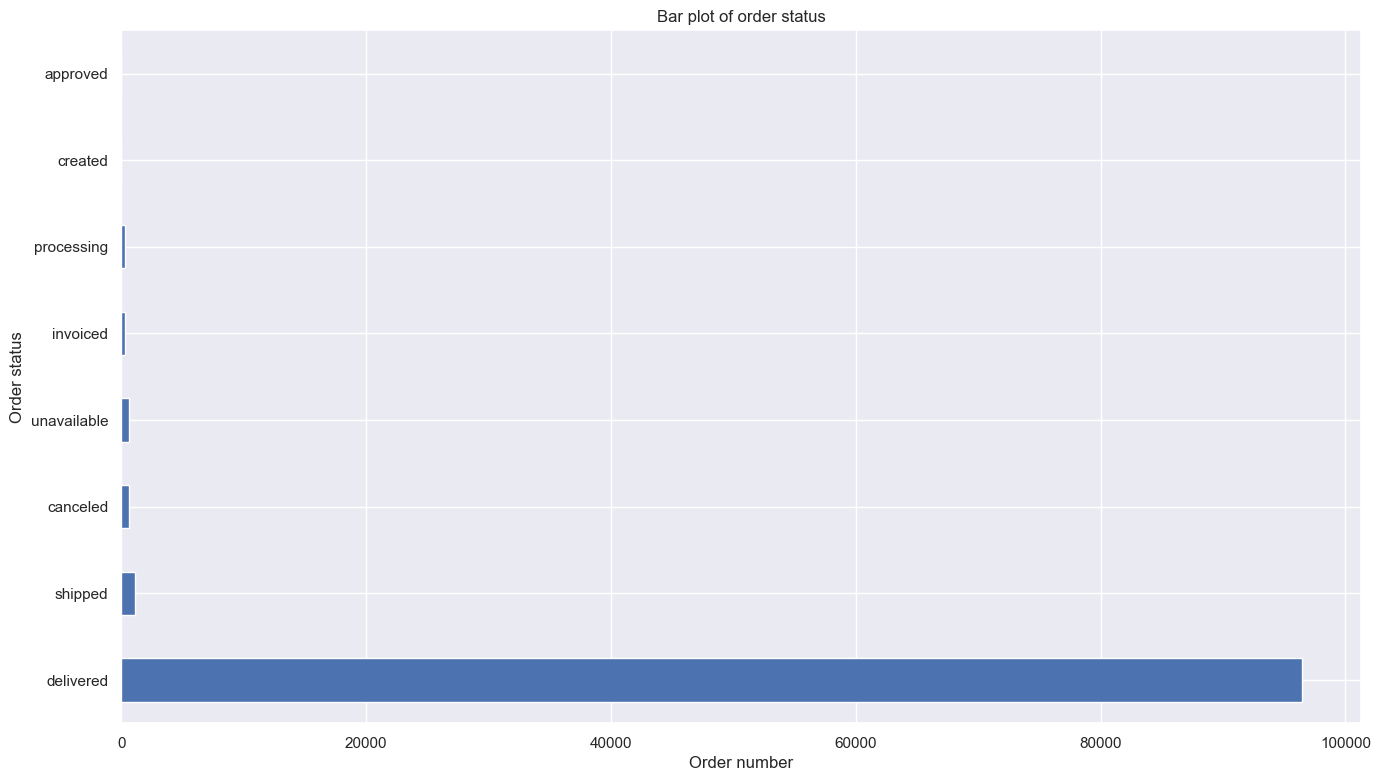

In [14]:
orders['order_status'].value_counts().plot(kind='barh', figsize=(16, 9))
plt.xlabel('Order number')
plt.ylabel('Order status')
plt.title('Bar plot of order status')

In [15]:
orders_res = orders.copy()
orders_res.index = orders_res['order_purchase_timestamp']
orders_res = orders_res.resample('1d').agg({
    'order_status': 'count'
}).rename(columns={'order_status': 'order_number'})

Text(2017-03-01 00:00:00, 900, 'Black Friday 2017')

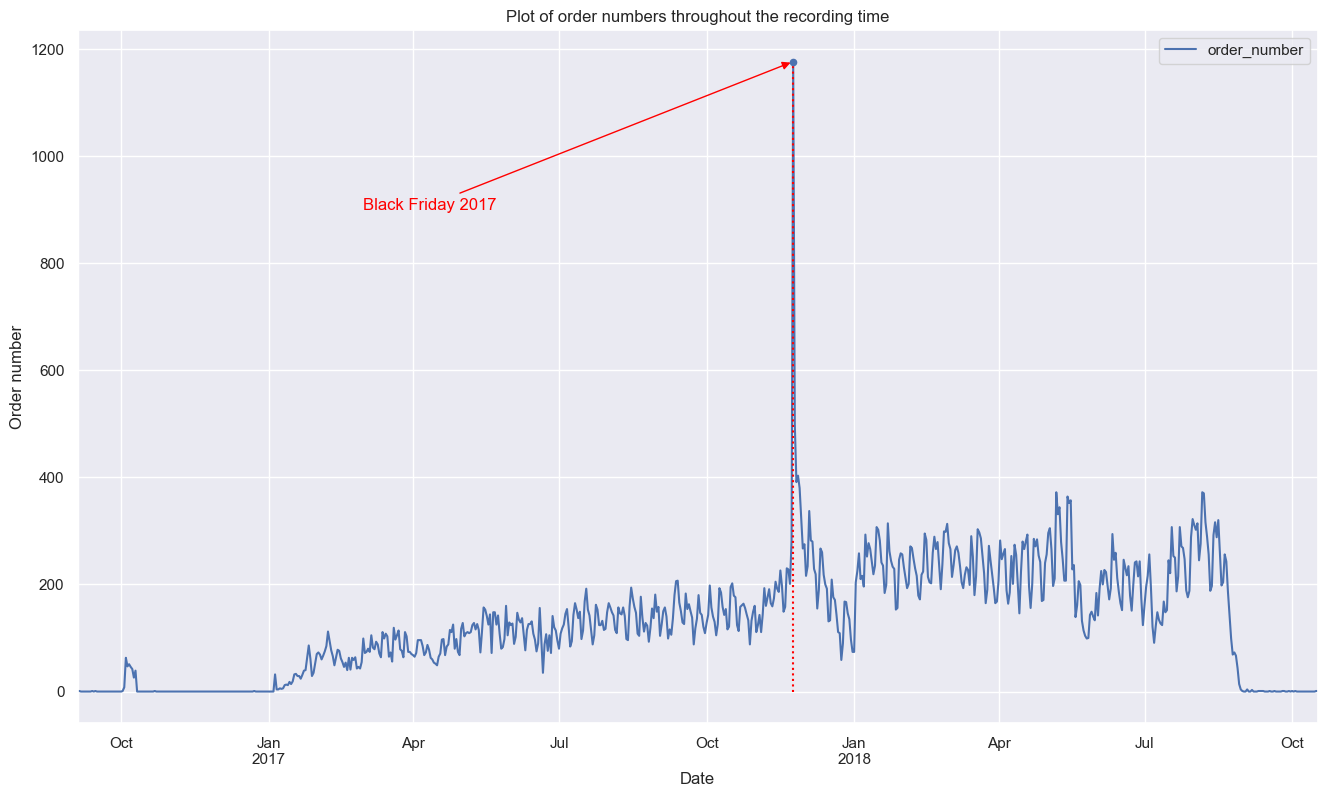

In [16]:
black_friday_2017 = '2017-11-24 00:00:00'
orders_res.plot(title='Plot of order numbers throughout the recording time', xlabel='Date', ylabel='Order number', figsize=(16, 9))
plt.vlines(x=black_friday_2017, ymin=orders_res['order_number'].min(), ymax=orders_res['order_number'].max(), color='red', linestyle=':')
plt.scatter(x=[black_friday_2017], y=[orders_res['order_number'].max()], s=20, zorder=2)
plt.annotate('Black Friday 2017', xy=[black_friday_2017, orders_res['order_number'].max()], xytext=['2017-03-01 00:00:00', 900], arrowprops=dict(arrowstyle='-|>', color='red'), color='red')

We have date for period since September 2016 to October 2018 but it seems that data was actively collected only since January 2017 to September 2018. Also we can see a spike on Black Friday 2018. We need to keep in mind that on Black Friday people orders the most frequently

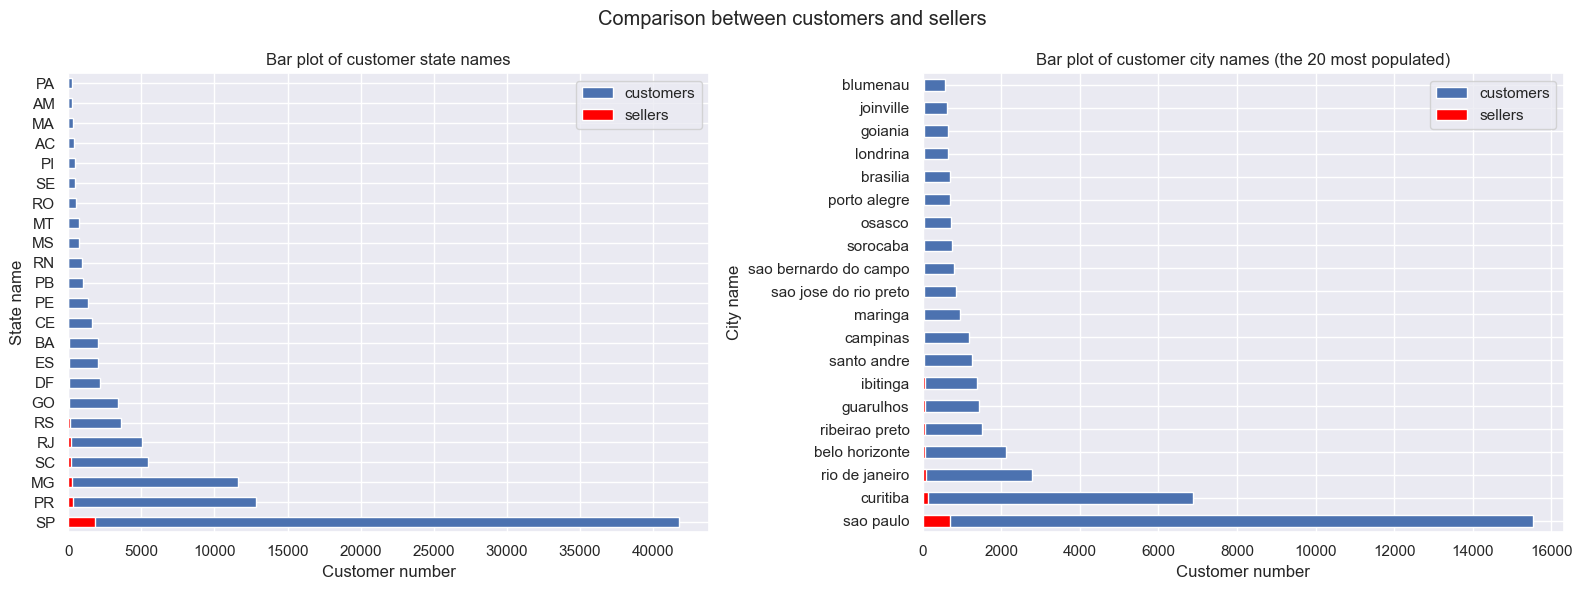

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

customers['customer_state'].value_counts().plot(kind='barh', ax=axes[0], label='customers')
sellers['seller_state'].value_counts().plot(kind='barh', ax=axes[0], color='red', label='sellers')
axes[0].set_xlabel('Customer number')
axes[0].set_ylabel('State name')
axes[0].set_title('Bar plot of customer state names')
axes[0].legend()

customers['customer_city'].value_counts()[:20].plot(kind='barh', ax=axes[1], label='customers')
sellers['seller_city'].value_counts()[:20].plot(kind='barh', ax=axes[1], color='red', label='sellers')
axes[1].set_xlabel('Customer number')
axes[1].set_ylabel('City name')
axes[1].set_title('Bar plot of customer city names (the 20 most populated)')
axes[1].legend()

fig.suptitle('Comparison between customers and sellers')
fig.tight_layout()

In [18]:
products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


Text(0.5, 1.0, 'Pairplot of products numerical features')

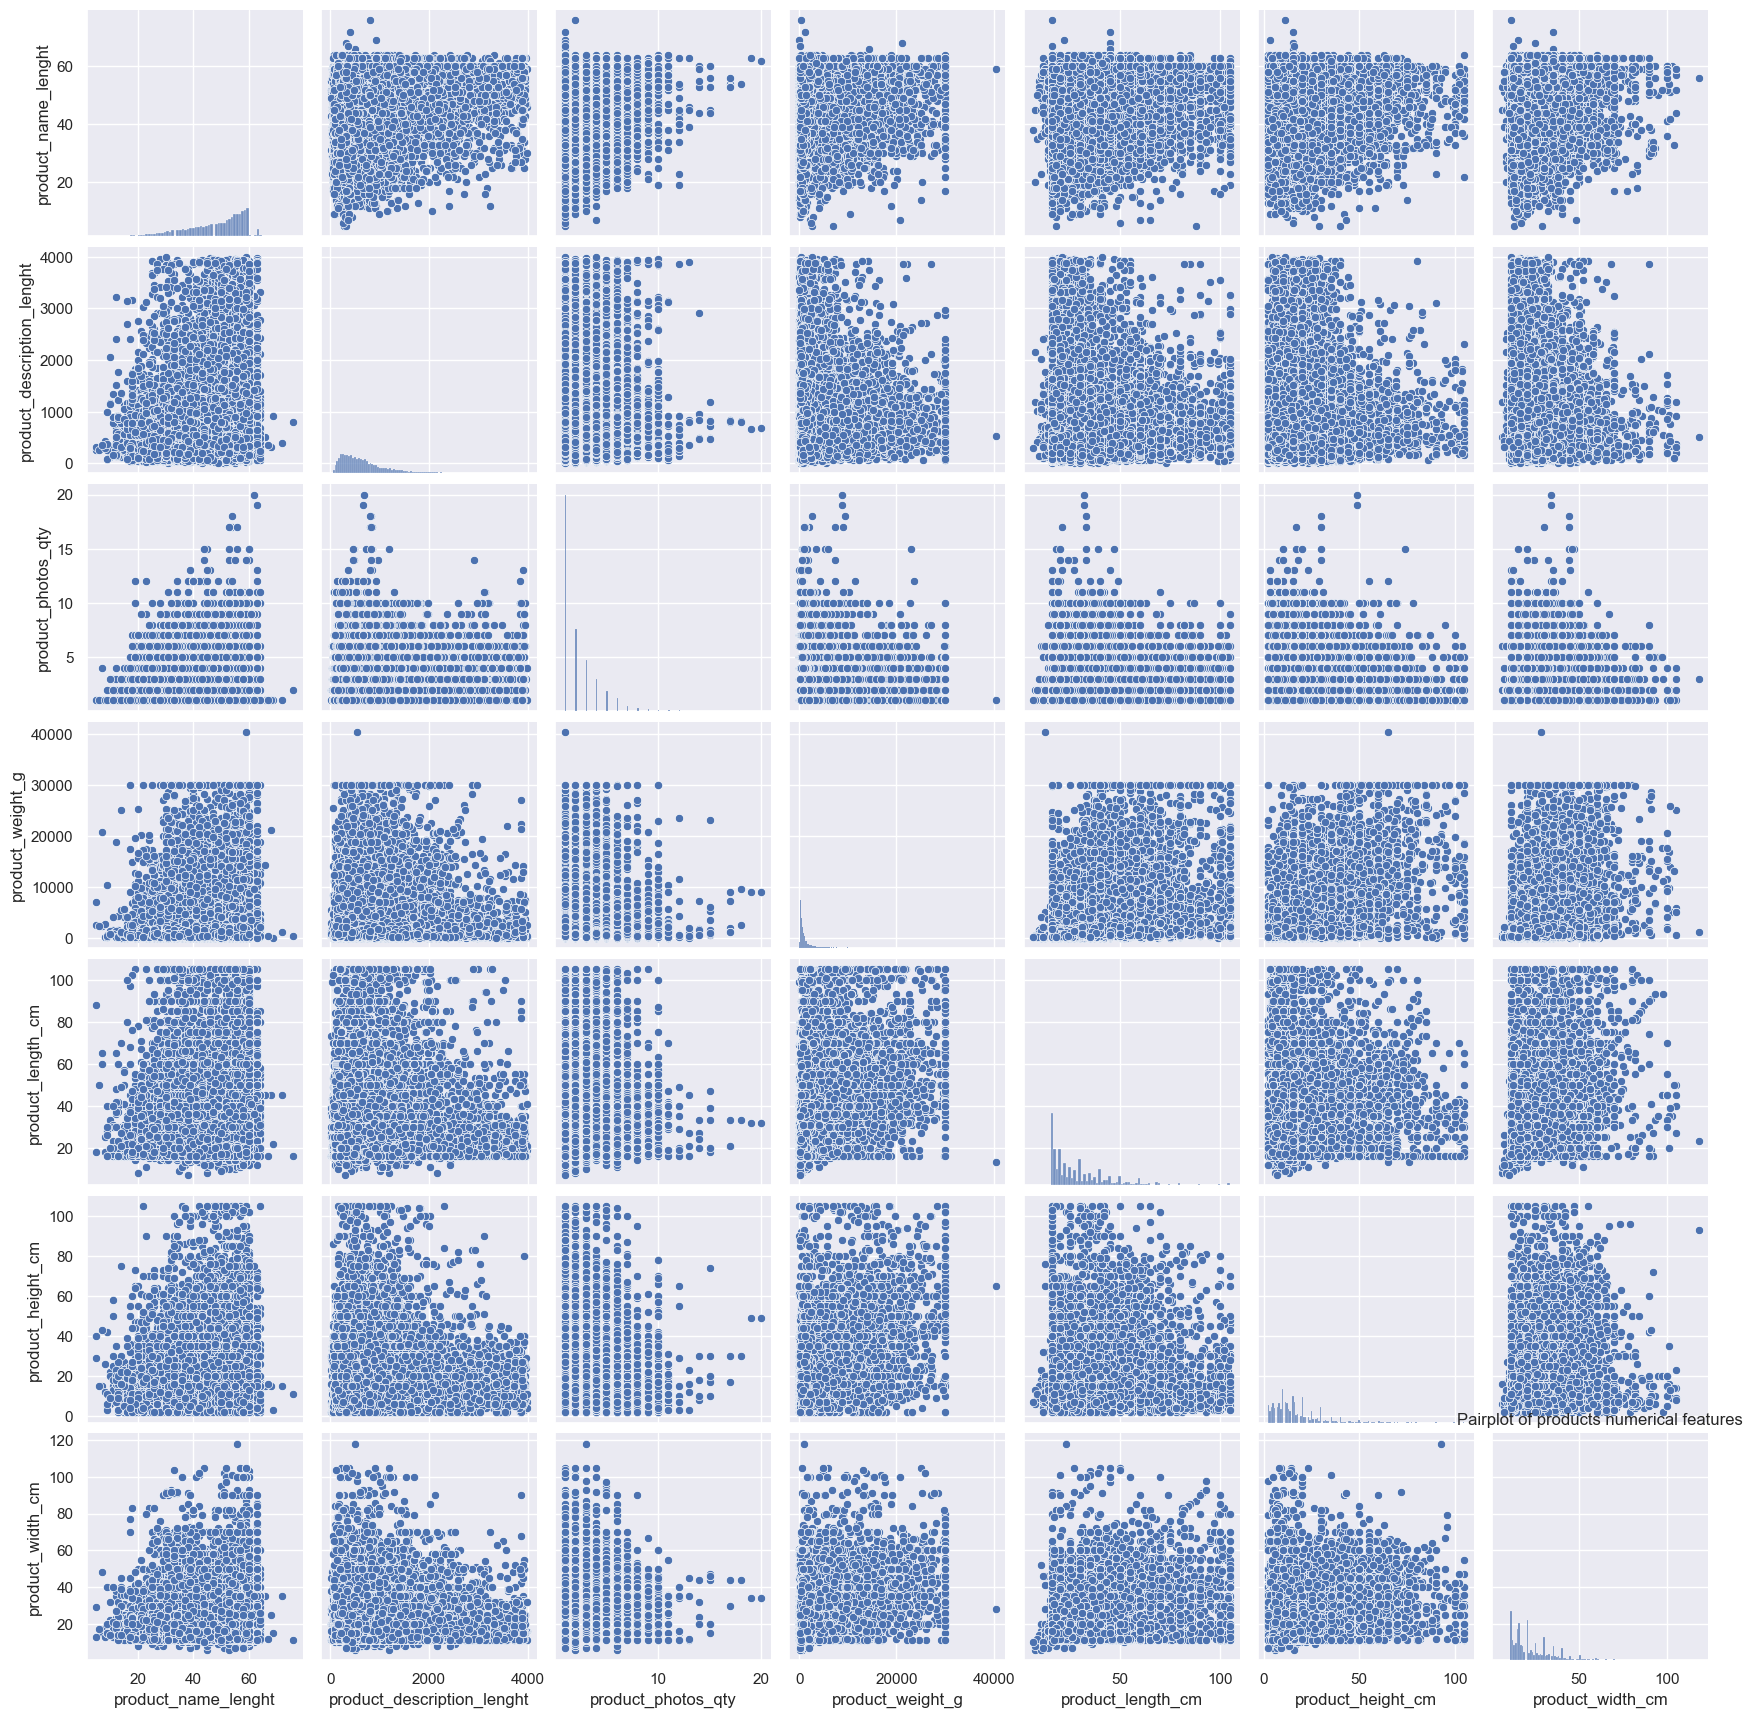

In [20]:
sns.pairplot(products)
plt.title('Pairplot of products numerical features')

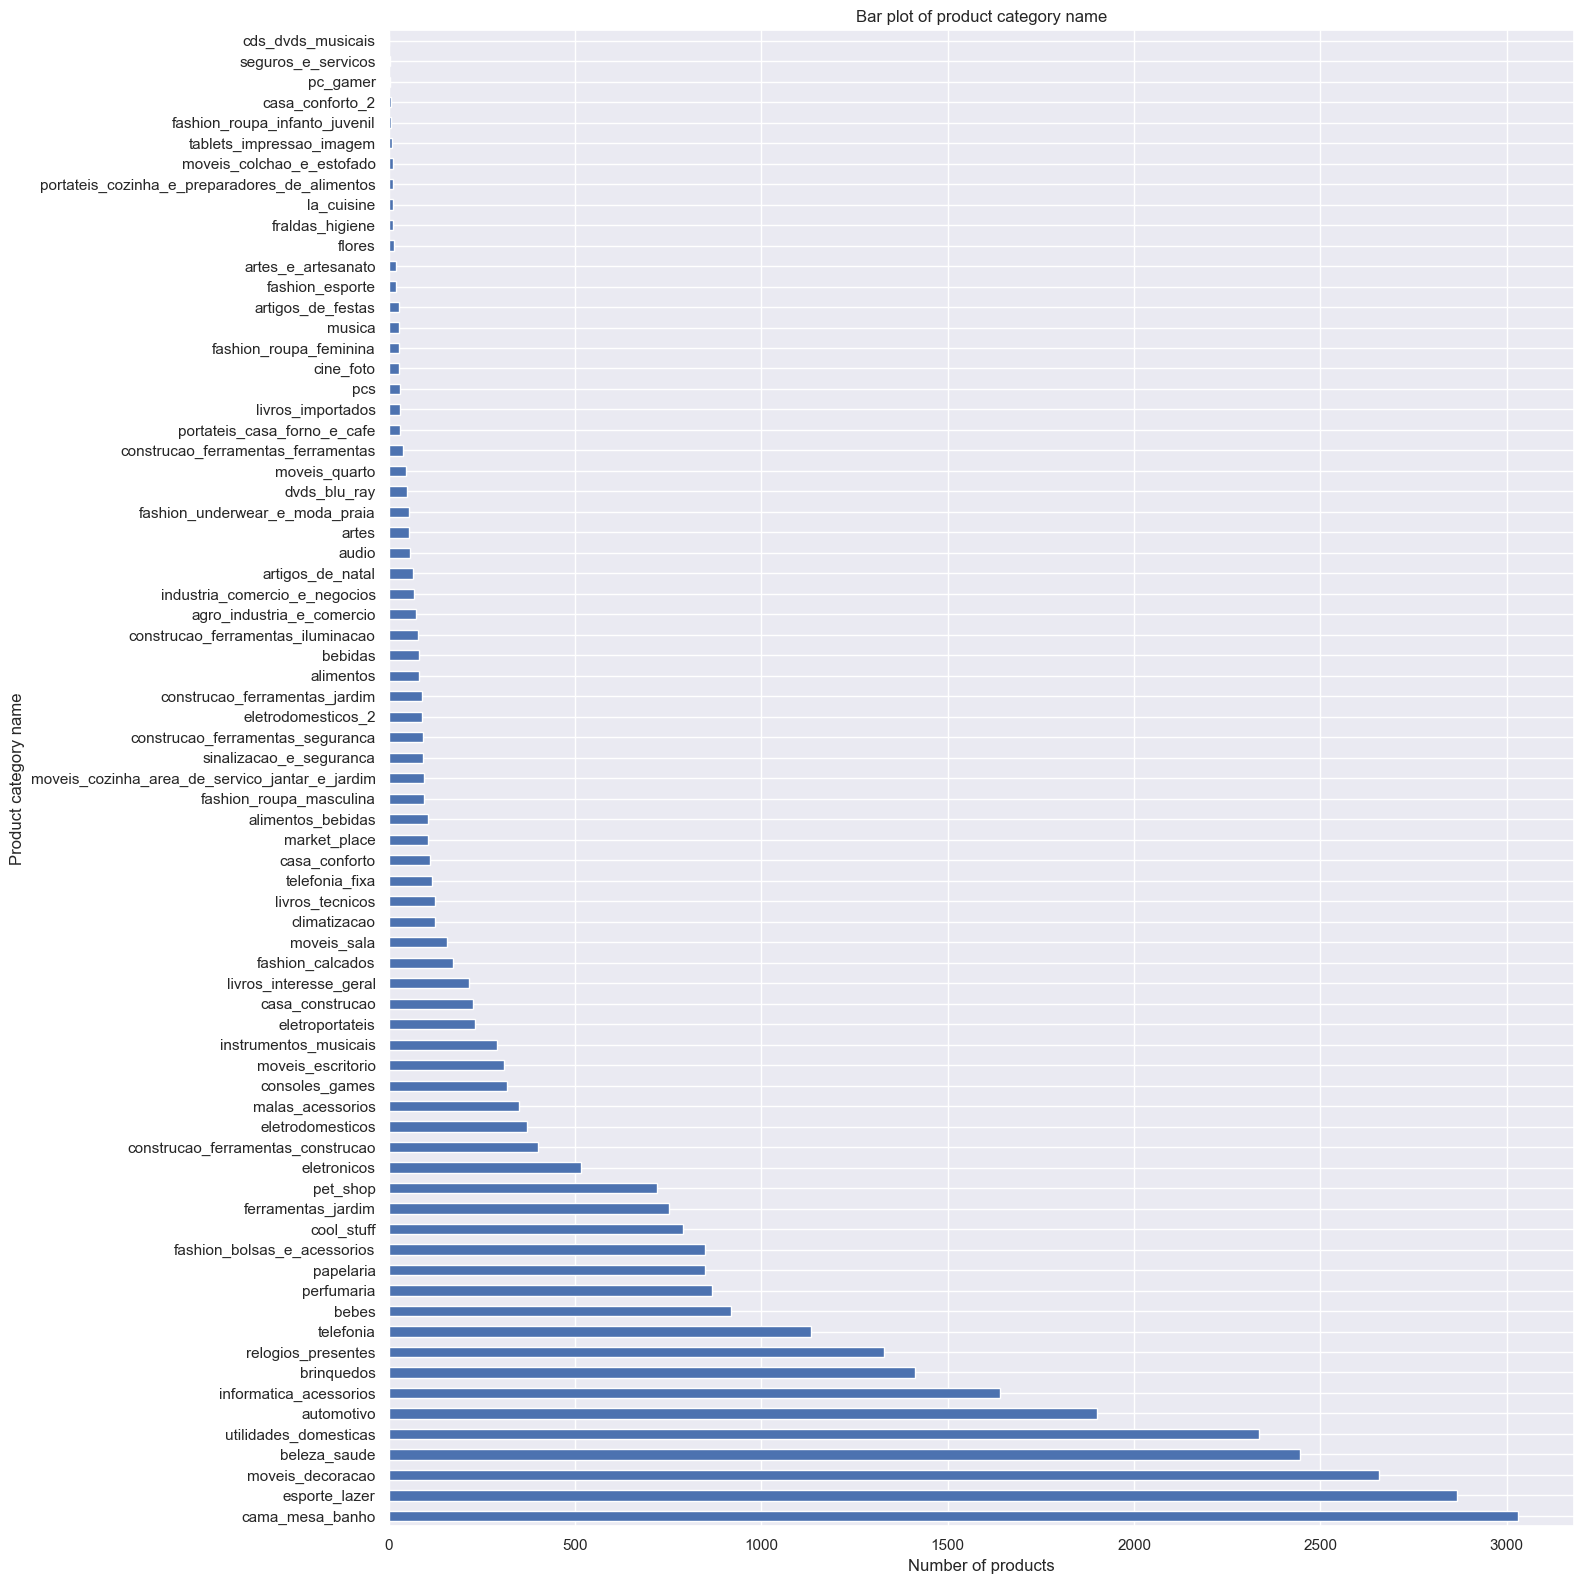

In [21]:
products['product_category_name'].value_counts().plot(kind='barh', figsize=(16, 16))
plt.xlabel('Number of products')
plt.ylabel('Product category name')
plt.title('Bar plot of product category name')
plt.tight_layout()

Let's see every 500-th geolocation from the dataset

In [22]:
# define the world map
world_map = folium.Map()

# instantiate a feature group
group = folium.map.FeatureGroup()

# loop through the geolocations and add each to the feature group
loop = zip(geolocation['geolocation_lat'][::500], geolocation['geolocation_lng'][::500])
for lat, lng, in loop:
    group.add_child(
        folium.vector_layers.CircleMarker(
            [lat, lng],
            radius=5, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

# add geolocations to map
world_map.add_child(group)

How we can see all geolocations are located in Brasil